### Loading Required Libraries

In [1]:
# import the necessary libraries

from modules import PreProcessing, functions
from sqlite3 import connect 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain
from collections import Counter
import nltk
import warnings
warnings.filterwarnings("ignore")

# to ensure all changes are reflected 
# in-case jupyter notebook was already oppened

from importlib import reload
reload(PreProcessing)
reload(functions)

project_dir = '/Users/nima/repository/Project_509'

In [2]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import TensorBoard

### Section 1 - Create a Suport vector machine 

In [3]:
databse_file = 'database.db'
main = connect(databse_file)

sql_statement_laod_data = '''
SELECT 
    reviews.id, 
    reviews.course_name, 
    review_text_clean.clean_sentence 

FROM review_text_clean
JOIN reviews ON 
    review_text_clean.review_id = reviews.id
'''

df = pd.read_sql_query(sql_statement_laod_data, main)

# create a new column that holds tokens of clean_sentence
df['tokens'] = df['clean_sentence'].apply(lambda x: x.split(' '))
df.sample(5)

,id,course_name,clean_sentence,tokens
27897,27897,foundations-data,sâuperb learn,"[sâuperb, learn]"
22370,22370,foundations-data,wow ive learn much open mind exactli want comp...,"[wow, ive, learn, much, open, mind, exactli, w..."
56789,56789,learning-how-to-learn,cours wa veri use discov wa bad student put lo...,"[cours, wa, veri, use, discov, wa, bad, studen..."
18822,18822,excel-essentials,good inform,"[good, inform]"
9474,9474,ai-for-everyone,great introductori cours deeper understand ai ...,"[great, introductori, cours, deeper, understan..."


In [4]:
# It is observed that there are tokens with only one character
# its best to remove them as well as they are just adding noise and complexity of the model

def remove_single_character_tokens(row, min_length=3):
    return [word for word in row['tokens'] if len(word) >= min_length]

df['tokens_keep'] = df.apply(remove_single_character_tokens, axis=1)

df['tokens_keep'].sample(5)

34983    [great, learn, experi, chuck, awesom, everi, s...
953      [absolut, fantast, enjoy, content, kept, engag...
54976    [simpl, yet, veri, use, tip, learn, better, ac...
43314    [veri, nice, interact, cours, like, python, in...
6574                                       [great, experi]
Name: tokens_keep, dtype: object

In [5]:
def exclude_words_that_are_rarely_used(counter_all, min_count=5):
    # remove words that appear less than min_count
    # this will be used to remove the words that are not frequently used
    # since the model can't learn from them effectively

    word_count_before = len(counter_all)
    counter_after = {token:count for token, count in counter_all.items() if count > min_count}
    word_count_after = len(counter_after)
    percentage_dropped = (word_count_before - word_count_after) / word_count_before * 100
    words_dropped = word_count_before - word_count_after

    print('%s rare words (%s) could be dropped to improve the model.' 
          % (f'{words_dropped:,}',f'{percentage_dropped:.1f}%'))
    
    print('unique words before: %s\nunique words after: %s' 
          % (f'{word_count_before:,}', f'{word_count_after:,}'))
    
    return counter_after
    
# using itertool count each elements in tokens column
counter_all = Counter(chain.from_iterable(df['tokens']))
counter_reduced = exclude_words_that_are_rarely_used(counter_all, min_count=5)
words_to_keep = counter_reduced.keys()

20,751 rare words (82.4%) could be dropped to improve the model.
unique words before: 25,194
unique words after: 4,443


In [11]:
# remove the elements in tokens that are not in words_to_keep
def return_words_to_use(row, words_to_keep):
    return [word for word in row['tokens'] if word in words_to_keep]

df['tokens_keep'] = df.apply(lambda row: return_words_to_use(row, words_to_keep), axis=1)


# difference in number of tokens before and after removing the words that are not used often
def get_number_of_words_dropped(row):
    return len(row['tokens']) - len(row['tokens_keep'])

df['number_of_words_dropped'] = df.apply(get_number_of_words_dropped, axis=1)

# sort the dataframe by number_of_words_dropped
df.sort_values(by='number_of_words_dropped', ascending=False, inplace=True)

df.head()

,id,course_name,clean_sentence,tokens,tokens_keep,number_of_words_dropped
9725,9725,excel-essentials,ù ø§ ø´ø§ø¡ ø§ùùù ùø§ ùùø© ø¥ùø§ ø¨ø§ù...,"[ù, ø§, ø´ø§ø¡, ø§ùùù, ùø§, ùùø©, ø¥ùø§...","[ù, ø§, ù, ù, ø¬ø¯ø§, ù, ù, ùù, ù, ø§, ø¬ø¯ø...",106
50478,50478,learning-how-to-learn,trã¨ intã©ress je le recommand pour le amoureu...,"[trã¨, intã©ress, je, le, recommand, pour, le,...","[trã¨, intã©ress, je, le, recommand, pour, le,...",79
50350,50350,learning-how-to-learn,ðñðµðºñð°ñð½ñð¹ ðºñññ ðð¾ð¹ ñð¸ð´ð±ñ...,"[ðñðµðºñð°ñð½ñð¹, ðºñññ, ðð¾ð¹, ñð¸ð...","[ðºñññ, ð½ðµ, ñð¾ð»ñðºð¾, ðºñññ, ð½ð¾,...",76
41757,41757,python,review korean korean mooc learner ì  ì´ ê°ì...,"[review, korean, korean, mooc, learner, ì, , ...","[review, mooc, learner, ì, ì, ì, ì, ì¸, ì, ì...",74
50939,50939,learning-how-to-learn,bu kur hakkä±nda bulunan yorumlardan birã§oäu...,"[bu, kur, hakkä±nda, bulunan, yorumlardan, bir...","[kur, iã§in, 2, kur, iã§in, de, coursera, ya, ...",68


In [7]:
# set seed for reproducibility
np.random.seed(12)

# get index of 20% of random data in the datafram for testing
test_index = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)

# set up the train and test
train = df[~df.index.isin(test_index)]
test = df[df.index.isin(test_index)]

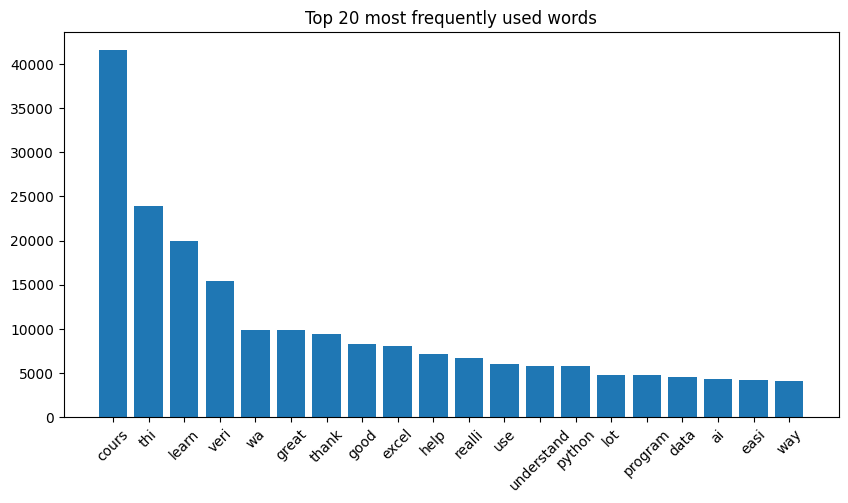

In [8]:
words_to_train_with = Counter(chain.from_iterable(train['tokens_keep']))

# plot the top 20 most frequently used in words_to_train_with
plt.figure(figsize=(10,5))
plt.title('Top 20 most frequently used words')
plt.bar(*zip(*words_to_train_with.most_common(20)))
plt.xticks(rotation=45)
plt.show()

In [21]:
# make a tuple of tokens_keep and classification

def prepare_train_data(row):
    x = {token:True for token in row['tokens_keep']}
    y = row['course_name']
    return (x, y)

train_data = train.apply(prepare_train_data, axis=1)
train_data[0]

({'got': True,
  'comprehens': True,
  'overview': True,
  'ai': True,
  'mean': True,
  'variou': True,
  'concept': True,
  'talk': True,
  'thi': True,
  'context': True,
  'excel': True,
  'cours': True,
  'one': True,
  'start': True,
  'solid': True,
  'ground': True,
  'five': True,
  'star': True,
  'thank': True,
  'andrew': True},
 'ai-for-everyone')

In [22]:
model_nb = nltk.NaiveBayesClassifier.train(train_data)

In [24]:
model_nb.show_most_informative_features(25)

Most Informative Features
                  python = True           python : excel- =   2439.6 : 1.0
                      ai = True           ai-for : excel- =   2143.0 : 1.0
                      dr = True           python : founda =    838.4 : 1.0
              cybersecur = True           introd : learni =    609.3 : 1.0
                 barbara = True           learni : ai-for =    537.1 : 1.0
                   cyber = True           introd : python =    522.1 : 1.0
                   secur = True           introd : excel- =    463.6 : 1.0
                   chuck = True           python : learni =    410.7 : 1.0
                 analyst = True           founda : learni =    406.6 : 1.0
                   audio = True           introd : ai-for =    396.1 : 1.0
                     web = True           python : founda =    368.2 : 1.0
                     ibm = True           introd : ai-for =    316.5 : 1.0
                  analyt = True           founda : learni =    279.7 : 1.0

In [30]:
# make a def to predict the course name using the model_nb
def predict_course_name(row, model, words_to_train_with):
    x = {token:True for token in row['tokens_keep'] if token in words_to_train_with}
        
    return model.classify(x)

test['predicted_course_name'] = test.apply(lambda row: predict_course_name(row, model_nb, words_to_train_with), axis=1)
test[['course_name', 'predicted_course_name']].sample(10)

,course_name,predicted_course_name
27801,foundations-data,excel-essentials
42576,python,python
31688,introduction-cybersecurity-cyber-attacks,introduction-cybersecurity-cyber-attacks
40392,python,python
7943,ai-for-everyone,python
36050,python-network-data,excel-essentials
22343,foundations-data,python
30391,introduction-cybersecurity-cyber-attacks,learning-how-to-learn
50275,learning-how-to-learn,learning-how-to-learn
57037,learning-how-to-learn,learning-how-to-learn


In [31]:
# calculate the accuracy of the model
accuracy = nltk.classify.accuracy(model_nb, train_data)
print('Accuracy of the model: %s' % f'{accuracy:.2%}')

Accuracy of the model: 49.71%


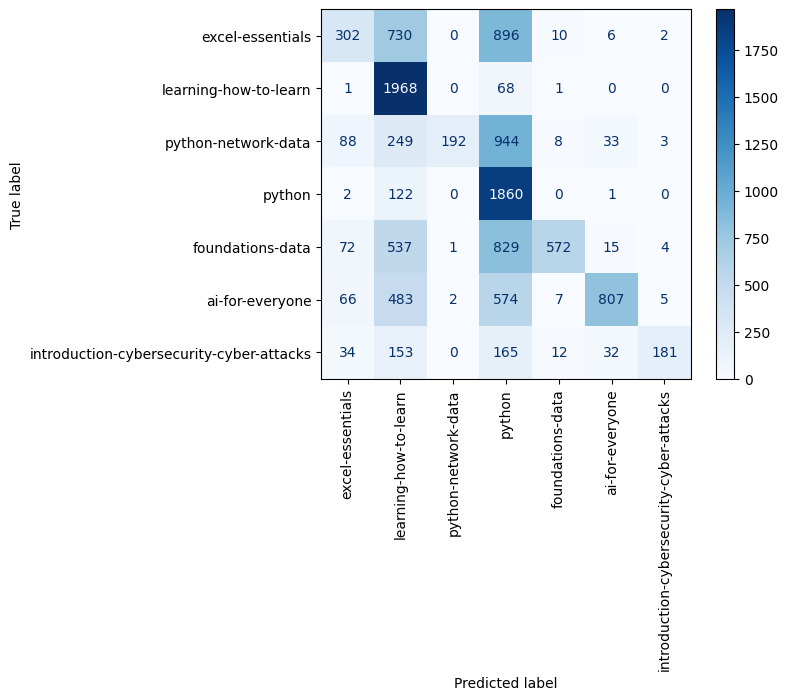

In [49]:
# calculate the confusion matrix of the model using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classification_labels = test['course_name'].unique()
cmx = confusion_matrix(test['course_name'], test['predicted_course_name'], labels=classification_labels)

ConfusionMatrixDisplay(confusion_matrix=cmx, display_labels=list(classification_labels)).plot( cmap='Blues',xticks_rotation='vertical')
plt.show()

In [50]:
# make a dataframe that holds the confusion matrix
cmx_df = pd.DataFrame(cmx, index=classification_labels, columns=classification_labels)
cmx_df

,excel-essentials,learning-how-to-learn,python-network-data,python,foundations-data,ai-for-everyone,introduction-cybersecurity-cyber-attacks
excel-essentials,302,730,0,896,10,6,2
learning-how-to-learn,1,1968,0,68,1,0,0
python-network-data,88,249,192,944,8,33,3
python,2,122,0,1860,0,1,0
foundations-data,72,537,1,829,572,15,4
ai-for-everyone,66,483,2,574,7,807,5
introduction-cybersecurity-cyber-attacks,34,153,0,165,12,32,181


In [52]:
# calculate the precision, recall, f1-measure of the model
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(test['course_name'], test['predicted_course_name'], labels=classification_labels)

# average the precision, recall, f1-measure
precision_avg = np.average(precision)
recall_avg = np.average(recall)
f1_avg = np.average(f1)

# show the results
print('precision: %s \nrecall: %s \nf1-measure: %s' % (f'{precision_avg:.2%}', f'{recall_avg:.2%}', f'{f1_avg:.2%}'))

precision: 72.86% 
recall: 45.64% 
f1-measure: 43.87%
